## Time series with time structured parameters and summary statistics

Idea: construct a model $p(x|\theta)$ with $\theta = (\theta_1,...\theta_n)$ and summary statistics $s(x) = (s_1(x),...s_m(x))$ s.t.


for all $i$ there exists a $j$, $j\leq m$, and $l$, $j\leq l$ such that
 
$p(s_{1:i}|\theta_{1:n} ) = p(s_{1:i}|\theta_{1:j}) $.

and 

$p(s_{1:i+1}|\theta_{1:n} ) = p(s_{1:i+1}|\theta_{1:l}) $.

### Examples:
1. Piecewise linear function:
 - $\theta_{1,2}$ : a and b of linear function f(x) = ax + b
 - $\theta_{3,4}$ : time of changing point cp, and a2 of second slope

 2. Sinusoidal waves with linearly increasing/decreasing amplitudes, and changing points at which this linear function changes.
 


In [1]:

%load_ext autoreload
%autoreload 2
import numpy as np
import scipy as scp
import matplotlib.pyplot as plt


import sys
sys.path.append('../code/')

import torch

In [2]:
# sbi
from sbi import utils as utils
from sbi import analysis as analysis
from sbi.inference.base import infer
from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi
from sbi.inference import SNPE_C
from utils.helpers import get_time

from utils.sbi_modulated_functions import Combined


In [147]:
def piecewise_linear(a1,b, a2,a3, cp1, cp2, add_noise=None):
    """
    Args:
        a1 (float): first slope
        b (float): offset
        a2 (float): second slope
        a3 (float): 3rd slope
        cp1, cp2 (float): changing points
        add_noise (None or float): None or scale of Gaussian noise on all variables

    Returns:
        x,y (arrays): x and y of piecewise linear function. 
    """
    if not add_noise == None:
        a1,b, a2,a3, cp1, cp2 = np.array([a1,b, a2,a3, cp1, cp2]) + scp.random.normal(scale=add_noise,size=6)       
    
    x = np.arange(0,10,0.01)
    y = np.zeros(x.shape)
    
    # first piece
    y[x<cp1] = (b+a1*x[x<cp1])
    
    # second piece     
    y[(x>=cp1) & (x<cp2)] = y[np.sum(x<cp1)-1] + a2* (x[(x>=cp1) & (x<cp2)]  - cp1) 
    
    # third piece
    y[x>=cp2] = y[np.sum(x<cp2)-1] + a3* (x[x>=cp2] - cp2) 
    
    
    print('x',x)
    print(y)
    return y


def piecewise_linear_first_batch(thetas):
    """
    Args:
        a1 (float): first slope
        b (float): offset
        a2 (float): second slope
        a3 (float): 3rd slope
        cp1, cp2 (float): changing points
        add_noise (None or float): None or scale of Gaussian noise on all variables

    Returns:
        x,y (arrays): x and y of piecewise linear function. 
    """
    
    a1 = thetas[0]
    b = thetas[1]
    a2 = np.float32(-2)
    a3 = np.float32(3)
    cp1 = np.float32(3)
    cp2 = np.float32(6)
    
    add_noise=0.1
    
    if not add_noise == None:
        a1,b, a2,a3, cp1, cp2 = np.array([a1,b, a2,a3, cp1, cp2]) + scp.random.normal(scale=add_noise,size=6)       
    
    x = torch.arange(0,10,0.01, dtype= torch.float32)
    y = torch.zeros(x.shape)
    
    # first piece
    y[x<cp1] = (b+a1*x[x<cp1])
    
    # second piece     
    y[(x>=cp1) & (x<cp2)] = y[torch.sum(x<cp1)-1] + a2* (x[(x>=cp1) & (x<cp2)]  - cp1) 
    
    # third piece
    y[x>=cp2] = y[torch.sum(x<cp2)-1] + a3* (x[x>=cp2] - cp2) 

    
    return y


def piecewise_linear_second_batch(thetas):
    """
    Args:
        a1 (float): first slope
        b (float): offset
        a2 (float): second slope
        a3 (float): 3rd slope
        cp1, cp2 (float): changing points
        add_noise (None or float): None or scale of Gaussian noise on all variables

    Returns:
        x,y (arrays): x and y of piecewise linear function. 
    """
    
    a1 = thetas[0]
    b = thetas[1]
    a2 = thetas[2]
    a3 = thetas[3]
    cp1 = np.float32(3)
    cp2 = np.float32(6)
    
    add_noise=0.1
    
    if not add_noise == None:
        a1,b, a2,a3, cp1, cp2 = np.array([a1,b, a2,a3, cp1, cp2]) + scp.random.normal(scale=add_noise,size=6)       
    
    x = torch.arange(0,10,0.01)
    y = torch.zeros(x.shape)
    
    # first piece
    y[x<cp1] = (b+a1*x[x<cp1])
    
    # second piece     
    y[(x>=cp1) & (x<cp2)] = y[torch.sum(x<cp1)-1] + a2* (x[(x>=cp1) & (x<cp2)]  - cp1) 
    
    # third piece
    y[x>=cp2] = y[torch.sum(x<cp2)-1] + a3* (x[x>=cp2] - cp2) 

    
    return y


def piecewise_linear_third_batch(thetas):
    """
    Args:
        a1 (float): first slope
        b (float): offset
        a2 (float): second slope
        a3 (float): 3rd slope
        cp1, cp2 (float): changing points
        add_noise (None or float): None or scale of Gaussian noise on all variables

    Returns:
        x,y (arrays): x and y of piecewise linear function. 
    """
    
    a1 = thetas[0]
    b = thetas[1]
    a2 = thetas[2]
    a3 = thetas[3]
    cp1 = thetas[4]
    cp2 = thetas[5]
    
    add_noise=0.1
    
    if not add_noise == None:
        a1,b, a2,a3, cp1, cp2 = np.array([a1,b, a2,a3, cp1, cp2]) + scp.random.normal(scale=add_noise,size=6)       
    
    x = torch.arange(0,10,0.01)
    y = torch.zeros(x.shape)
    
    # first piece
    y[x<cp1] = (b+a1*x[x<cp1])
    
    # second piece     
    y[(x>=cp1) & (x<cp2)] = y[torch.sum(x<cp1)-1] + a2* (x[(x>=cp1) & (x<cp2)]  - cp1) 
    
    # third piece
    y[x>=cp2] = y[torch.sum(x<cp2)-1] + a3* (x[x>=cp2] - cp2) 

    
    return y

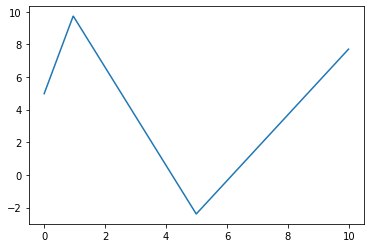

In [148]:
true_params = [5, 5, -3, 2, 1, 5]

x_lin = torch.arange(0,10,0.01)

plt.plot(x_lin, piecewise_linear_third_batch(true_params))

### Define prior and summary stats dependent on prior

-4.445427747631276 3.1275657172727334 7.112089109432761 -5.0476187679386655 3.512915366259395 6.431303551124101
x [0.   0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13
 0.14 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27
 0.28 0.29 0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39 0.4  0.41
 0.42 0.43 0.44 0.45 0.46 0.47 0.48 0.49 0.5  0.51 0.52 0.53 0.54 0.55
 0.56 0.57 0.58 0.59 0.6  0.61 0.62 0.63 0.64 0.65 0.66 0.67 0.68 0.69
 0.7  0.71 0.72 0.73 0.74 0.75 0.76 0.77 0.78 0.79 0.8  0.81 0.82 0.83
 0.84 0.85 0.86 0.87 0.88 0.89 0.9  0.91 0.92 0.93 0.94 0.95 0.96 0.97
 0.98 0.99 1.   1.01 1.02 1.03 1.04 1.05 1.06 1.07 1.08 1.09 1.1  1.11
 1.12 1.13 1.14 1.15 1.16 1.17 1.18 1.19 1.2  1.21 1.22 1.23 1.24 1.25
 1.26 1.27 1.28 1.29 1.3  1.31 1.32 1.33 1.34 1.35 1.36 1.37 1.38 1.39
 1.4  1.41 1.42 1.43 1.44 1.45 1.46 1.47 1.48 1.49 1.5  1.51 1.52 1.53
 1.54 1.55 1.56 1.57 1.58 1.59 1.6  1.61 1.62 1.63 1.64 1.65 1.66 1.67
 1.68 1.69 1.7  1.71 1.72 1.73 1.7

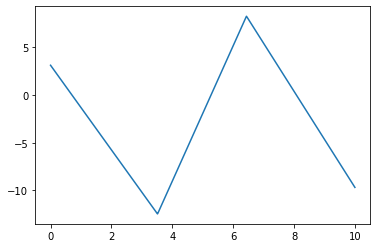

In [149]:
"""
Priors
"""

b = scp.random.uniform(0,10)
a1 = scp.random.uniform(-10,0)
a2 = scp.random.uniform(0,10)
a3 = scp.random.uniform(-10,0)
cp1 = scp.random.uniform(2,4)
cp2 = scp.random.uniform(5,8)


x = piecewise_linear(a1,b, a2,a3, cp1, cp2)

plt.plot(x_lin, x)

In [159]:
"""
Summary stats
"""

def extract_sumstats(y,max_time=10):
    """
    Extract some sumstats for piecewise linear fct with specified prior 
    !the information in the sumstats is highly dependent on the prior!
    Args:
        x ([array]): time axis of time series
        y ([array]): 1d time series
        max_time (float, optional): maximal time to calculate sumstats on. Defaults to 10.

    Returns:
       s [array]: summary stats of time series, with np.nan for non-calculated sumstats
    """
    
    # artificial masking of y 
    
    x = torch.arange(0,10,0.01, dtype=torch.float32)


    y = np.copy(y)
    
    batch_list = []
    # first batch of sumstats for times <4
    
    for batch in y:
        
        batch[x>max_time] = np.nan
    
        s = np.zeros(7) * np.nan
        
        s[0] = np.float32(batch[0])
        s[1] = np.nanmin(batch[x<4])
        
        #print(type(s[0]), type(s[1]))
        s[2] = x[np.nanargmin(batch[x<4])]

        # second batch of sumstats for times > 4
        if max_time >= 4 :
            s[3] = np.nanmax(batch[(x>=4)&(x<8)])
            s[4] = x[np.nanargmax(batch[(x>=4)&(x<8)])] + 4

        # third batch of sumstats for times > 5
        if max_time >= 5:
            s[5] = np.nanmin(batch[x>=5])
            s[6] = x[np.nanargmin(batch[x>=5])] + 5
            
        s = np.float32(s)
    
            
        batch_list.append(torch.from_numpy(s))

    return torch.stack(batch_list)

    

## cosine waves

WORK IN PROGRESS

same, but more ellaborated summary stats are needed

In [152]:
def cosine_waves(a1,b,a2,cp,f_1=1, f_2=1, return_factors=False):
    """
    Args:
        a1 (float): first slope
        b (float): offset (starting amplitude)
        a2 (float): second slope
        cp (float): changing point
        f_1 (float): first freq
        f_2 (float): second freq

    Returns:
        [type]: [description]
    """
    x = np.arange(0,10,0.01)
    y = np.zeros(x.shape)
    factor1 = (b+a1*x[x<cp])
    factor1[factor1<0] = 0
    y[x<cp] = factor1 * np.cos(2*np.pi * f_1 * x[x<cp])
     
    factor2= y[np.sum(x<cp)-1] + a2* (x[x>=cp] - cp) 
    factor2[factor2<0] = 0

    y[x>=cp] = (factor2) * np.cos(2*np.pi * f_2 * x[x>=cp]) 

    if return_factors:
        return x,y, factor1, factor2
    else:
        return x,y

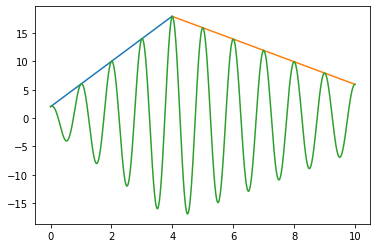

In [153]:
x,y,f1,f2=cosine_waves(4,2,-2,4, return_factors=True  )

plt.plot(x[:len(f1)],f1)
plt.plot(x[-len(f2):],f2)
plt.plot(x,y)

In [154]:
def cosine_waves_2(a1,b,a2,a3, cp1, cp2, f_1=1, f_2=1,f_3=1, return_factors=False):
    """
    Args:
        a1 (float): first slope
        b (float): offset
        ai (float): slopes
        cpi (float): changing points
        f_i (float): first freqs
        
    Returns:
        [type]: [description]
    """
    x = np.arange(0,10,0.01)
    y = np.zeros(x.shape)
    factor1 = (b+a1*x[x<cp1])
    factor1[factor1<0] = 0
    y[x<cp1] = factor1 * np.cos(2*np.pi * f_1 * x[x<cp1])
     
    factor2= y[np.sum(x<cp1)-1] + a2* (x[(x>=cp1) & (x<cp2)] - cp1) 
    factor2[factor2<0] = 0
    y[(x>=cp1) & (x<cp2)] = (factor2) * np.cos(2*np.pi * f_2 * x[(x>=cp1) & (x<cp2)]) 
    
    factor3= y[np.sum(x<cp2)-1] + a3* (x[x>=cp2] - cp2) 
    factor3[factor3<0] = 0

    y[x>=cp2] = (factor3) * np.cos(2*np.pi * f_3 * x[x>=cp2]) 

    if return_factors:
        return x,y, factor1, factor2, factor3
    else:
        return x,y
    
    
def cosine_waves_2_first(thetas):
    """
    Args:
        a1 (float): first slope
        b (float): offset
        ai (float): slopes
        cpi (float): changing points
        f_i (float): first freqs
        
    Returns:
        [type]: [description]
    """
    
    a1 = thetas[0]
    b = thetas[1]
    a2=-3
    a3=3
    cp1=2
    cp2=6
    f_1=1
    f_2=1
    f_3=1
    
    return_factors=False
    
    x = torch.arange(0,10,0.01, dtype= torch.float32)
    y = torch.zeros(x.shape)
    factor1 = (b+a1*x[x<cp1])
    factor1[factor1<0] = 0
    y[x<cp1] = factor1 * np.cos(2*np.pi * f_1 * x[x<cp1])
     
    factor2= y[np.sum(x<cp1)-1] + a2* (x[(x>=cp1) & (x<cp2)] - cp1) 
    factor2[factor2<0] = 0
    y[(x>=cp1) & (x<cp2)] = (factor2) * np.cos(2*np.pi * f_2 * x[(x>=cp1) & (x<cp2)]) 
    
    factor3= y[torch.sum(x<cp2)-1] + a3* (x[x>=cp2] - cp2) 
    factor3[factor3<0] = 0

    y[x>=cp2] = (factor3) * np.cos(2*np.pi * f_3 * x[x>=cp2]) 

    if return_factors:
        return x,y, factor1, factor2, factor3
    else:
        return x,y

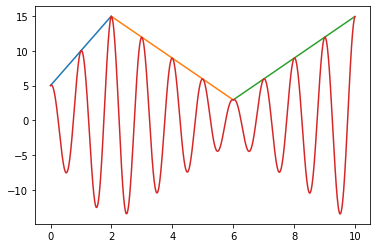

In [155]:
x,y,f1,f2,f3=cosine_waves_2(5,5,
                            -3,3,
                            2,6, return_factors=True)

plt.plot(x[:len(f1)],f1)
plt.plot(x[len(f1):-len(f3)],f2)
plt.plot(x[-len(f3):],f3)

plt.plot(x,y)

In [188]:
#parameter a1,b,a2,a3, cp1, cp2

prior_min = [3,3,-5,1,0,4]  

prior_max = [7, 7, -1, 3, 2, 6]

num_simulations=1000

### first round:

prior1 = utils.torchutils.BoxUniform(low=prior_min[0:2], high = prior_max[0:2])

print(prior_min[0:2])
print(prior1)

inf = SNPE_C(prior1, density_estimator="nsf")

density_estimator = 'nsf'


simulator_stats, prior = prepare_for_sbi(piecewise_linear_first_batch, prior1)

inference = SNPE_C(prior, density_estimator=density_estimator)

theta, x_without = simulate_for_sbi(
    simulator_stats,
    proposal=prior,
    num_simulations=num_simulations,
    num_workers=4,
)

[3, 3]
BoxUniform(Uniform(low: torch.Size([2]), high: torch.Size([2])), 1)


/tmp/ipykernel_407341/818838977.py:59: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  a1,b, a2,a3, cp1, cp2 = np.array([a1,b, a2,a3, cp1, cp2]) + scp.random.normal(scale=add_noise,size=6)
/tmp/ipykernel_407341/818838977.py:59: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  a1,b, a2,a3, cp1, cp2 = np.array([a1,b, a2,a3, cp1, cp2]) + scp.random.normal(scale=add_noise,si

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

In [189]:
x_without

theta.shape

torch.Size([1000, 2])

In [190]:
x = extract_sumstats(x_without)

In [191]:

inf = inf.append_simulations(theta, x)
density_estimator = inf.train()

posterior = inf.build_posterior(density_estimator)

Neural network successfully converged after 50 epochs.


In [192]:
true_params = [5, 5, -3, 2, 1, 5]


obs_real = piecewise_linear_first_batch(true_params).unsqueeze(0)

print(obs_real.shape)

obs_real_stats = extract_sumstats(obs_real)


print(obs_real_stats.shape)

torch.Size([1, 1000])
torch.Size([1, 7])


In [193]:
num_samples = 100

samples = posterior.sample((num_samples,), x=obs_real_stats)

proposal1 = posterior.set_default_x(obs_real_stats)

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

In [194]:
#### second round



prior2 = utils.torchutils.BoxUniform(low=prior_min[2:4], high = prior_max[2:4])


prior_combined =Combined(proposal1, prior2, number_params_1=2)


print('prior combined', prior_combined.sample((10,)).shape)
#print('prop',prior2.sample((10,)).shape)


inf = SNPE_C(prior_combined, density_estimator="nsf")

density_estimator = 'nsf'


simulator_stats, prior = prepare_for_sbi(piecewise_linear_second_batch, prior_combined)

inference = SNPE_C(prior, density_estimator=density_estimator)

theta, x_without = simulate_for_sbi(
    simulator_stats,
    proposal=prior,
    num_simulations=num_simulations,
    num_workers=4,
)

Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

theta pos size torch.Size([10, 2])
theta prior size torch.Size([10, 2])
2
theta tensor([[ 4.5445,  5.1033, -4.5906,  1.9855],
        [ 4.5582,  5.0073, -3.6891,  2.3228],
        [ 4.8479,  4.8905, -1.7281,  2.9880],
        [ 4.5432,  4.9963, -3.8988,  1.0819],
        [ 5.1429,  5.0243, -2.6934,  1.9897],
        [ 5.1060,  5.0104, -1.3216,  1.1026],
        [ 4.5607,  5.0094, -3.2369,  1.0316],
        [ 4.9826,  5.1468, -2.1346,  1.5221],
        [ 4.9201,  5.1421, -3.5231,  2.8388],
        [ 5.4084,  4.8953, -1.8391,  1.8172]])
prior combined torch.Size([10, 4])


Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

theta pos size torch.Size([1, 2])
theta prior size torch.Size([1, 2])
2
theta tensor([[ 4.8206,  4.9089, -1.2181,  2.0434]])


Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

theta pos size torch.Size([2])
theta prior size torch.Size([2])
1
true
theta tensor([[ 4.8058,  4.9760, -4.0282,  1.9948]])


Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

theta pos size torch.Size([1, 2])
theta prior size torch.Size([1, 2])
2
theta tensor([[ 5.2294,  5.0998, -4.6917,  1.3405]])
tensor([-1.4719])


Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

theta pos size torch.Size([2])
theta prior size torch.Size([2])
1
true
theta tensor([[ 5.5638,  4.8966, -3.8362,  2.5622]])


Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

theta pos size torch.Size([2])
theta prior size torch.Size([2])
1
true
theta tensor([[ 4.7979,  4.9352, -1.5374,  1.6032]])


Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

theta pos size torch.Size([2])
theta prior size torch.Size([2])
1
true
theta tensor([[ 5.6816,  5.0731, -1.9385,  2.3505]])


Drawing 2 posterior samples:   0%|          | 0/2 [00:00<?, ?it/s]

theta pos size torch.Size([2, 2])
theta prior size torch.Size([2, 2])
2
theta tensor([[ 6.9070,  5.1454, -4.3308,  2.8702],
        [ 4.4996,  5.0422, -2.0539,  1.9020]])


Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

theta pos size torch.Size([2])
theta prior size torch.Size([2])
1
true
theta tensor([[ 4.9358,  5.1364, -2.7437,  2.2096]])


Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

theta pos size torch.Size([1, 2])
theta prior size torch.Size([1, 2])
2
theta tensor([[ 4.7091,  5.1396, -2.3432,  2.5378]])


Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

theta pos size torch.Size([1, 2])
theta prior size torch.Size([1, 2])
2
theta tensor([[ 4.8333,  5.0641, -2.4420,  1.1698]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

theta pos size torch.Size([1000, 2])
theta prior size torch.Size([1000, 2])
2
theta tensor([[ 4.7156,  5.0335, -4.1066,  1.7775],
        [ 4.7893,  4.9969, -2.9337,  1.5763],
        [ 5.7264,  5.1204, -1.2305,  2.0460],
        ...,
        [ 4.7744,  5.0395, -4.7573,  2.3149],
        [ 5.2358,  5.0405, -1.2377,  2.9043],
        [ 5.8987,  5.3012, -3.2155,  2.4411]])


Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

In [195]:
x = extract_sumstats(x_without)


print(theta.shape)

inf = inf.append_simulations(theta, x)

print(inf)
density_estimator = inf.train()

posterior2 = inf.build_posterior(density_estimator)

torch.Size([1000, 4])
Neural network successfully converged after 53 epochs.


In [196]:



#print(proposal2.log_prob(theta))

samples = posterior2.sample((num_samples,), x=obs_real_stats)

proposal2 = posterior2.set_default_x(obs_real_stats)

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

In [197]:
#### third round



prior3 = utils.torchutils.BoxUniform(low=prior_min[4:6], high = prior_max[4:6])


prior_combined2 =Combined(proposal2, prior3, number_params_1=4)



inf = SNPE_C(prior_combined2, density_estimator="nsf")

density_estimator = 'nsf'


simulator_stats, prior = prepare_for_sbi(piecewise_linear_third_batch, prior_combined2)

inference = SNPE_C(prior, density_estimator=density_estimator)

theta, x_without = simulate_for_sbi(
    simulator_stats,
    proposal=prior,
    num_simulations=num_simulations,
    num_workers=4,
)

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

theta pos size torch.Size([1, 4])
theta prior size torch.Size([1, 2])
2
theta tensor([[ 4.9334,  5.0025, -2.1277,  2.8904,  1.7452,  4.0055]])


Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

theta pos size torch.Size([4])
theta prior size torch.Size([2])
1
true
theta tensor([[ 4.8857,  4.9876, -3.0050,  2.7125,  1.6141,  4.0685]])


Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

theta pos size torch.Size([1, 4])
theta prior size torch.Size([1, 2])
2
theta tensor([[ 5.2178,  5.0955, -2.0547,  1.3001,  1.5858,  5.9578]])
tensor([-2.6068])


Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

theta pos size torch.Size([4])
theta prior size torch.Size([2])
1
true
theta tensor([[ 5.5180,  4.7822, -2.0752,  2.6079,  0.8336,  5.1890]])


Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

theta pos size torch.Size([4])
theta prior size torch.Size([2])
1
true
theta tensor([[ 4.7737,  5.0442, -1.7481,  2.7959,  1.2092,  5.0756]])


Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

theta pos size torch.Size([4])
theta prior size torch.Size([2])
1
true
theta tensor([[ 4.7578,  5.0060, -2.6181,  2.8089,  0.9884,  5.5340]])


Drawing 2 posterior samples:   0%|          | 0/2 [00:00<?, ?it/s]

theta pos size torch.Size([2, 4])
theta prior size torch.Size([2, 2])
2
theta tensor([[ 4.7919,  4.9200, -2.1588,  2.3784,  0.0420,  5.2287],
        [ 5.1664,  4.9459, -2.4926,  2.8886,  0.2976,  5.6666]])


Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

theta pos size torch.Size([4])
theta prior size torch.Size([2])
1
true
theta tensor([[ 4.7677,  5.1337, -1.4090,  2.9477,  1.0874,  5.6188]])


Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

theta pos size torch.Size([1, 4])
theta prior size torch.Size([1, 2])
2
theta tensor([[ 4.8996,  5.0007, -1.5910,  2.4129,  0.1428,  4.4213]])


Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

theta pos size torch.Size([1, 4])
theta prior size torch.Size([1, 2])
2
theta tensor([[ 4.5558,  4.9302, -2.3229,  2.7112,  1.3367,  5.9942]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

theta pos size torch.Size([1000, 4])
theta prior size torch.Size([1000, 2])
2
theta tensor([[ 4.8801,  4.9845, -1.4329,  2.7704,  0.9072,  5.9328],
        [ 5.1411,  4.9165, -1.8617,  2.9534,  0.3839,  5.3898],
        [ 5.0122,  5.2211, -1.7846,  2.3642,  1.3911,  5.7792],
        ...,
        [ 5.3790,  4.9612, -1.8394,  2.8533,  0.2564,  4.4781],
        [ 5.0242,  4.9440, -1.5488,  2.4872,  0.7543,  5.6665],
        [ 5.8005,  4.9582, -1.9723,  1.4518,  1.5045,  4.9215]])


Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
x = extract_sumstats(x_without)


print(theta.shape)

inf = inf.append_simulations(theta, x)

print(inf)
density_estimator = inf.train()

posterior3 = inf.build_posterior(density_estimator)

torch.Size([1000, 6])


In [ ]:
samples = posterior3.sample((num_samples,), x=obs_real_stats)

In [ ]:
print(samples.shape)


from sbi import analysis as analysis

In [ ]:
from joblib import Parallel, delayed

num_workers = 4

s_x = Parallel(
        n_jobs=num_workers,
        verbose=100,
        pre_dispatch="1.5*n_jobs",
        backend="multiprocessing",
    )(delayed(piecewise_linear_third_batch)(sample) for sample in samples)



fig, ax = plt.subplots(1, 1)
ax.set_title("Simulating from posterior (without summary stats)")
for s in s_x:
    im = plt.plot(x_lin, s)
    plt.ylim(-10,30)
    
    
obs_real = piecewise_linear_third_batch(true_params)




fig, ax = plt.subplots(1, 1)
ax.set_title("Simulating from posterior (without summary stats)")
plt.plot(x_lin, obs_real)
plt.ylim(-10,30)


In [ ]:
limits = [list(tup) for tup in zip(prior_min, prior_max)]

true_params = torch.tensor([[5, 5, -3, 2, 1, 5]])

parameter_names = ['a1', 'b', 'a2', 'a3', 'cp1', 'cp2' ]

fig, axes = analysis.pairplot(
    samples,
    limits=limits,
    ticks=limits,
    figsize=(5, 5),
    points=true_params[0:2],
    points_offdiag={"markersize": 6},
    points_colors="r",
    #tick_labels=parameter_names
    labels=parameter_names,
)